In [1]:
# Date: 8/29/2021
# Author: Shreesha Jagadeesh
# Purpose: Download CIFAR dataset and built classifier models using CNN

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
import numpy as np
from matplotlib import pyplot as plt
# %%display matplotlib inline

In [4]:
tf.random.set_seed(42)

from numpy.random import seed
seed(1)

# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

In [5]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
# The 2nd line is extra for the CNN because it has the CNN, MaxPooling2D and Flatten

# from keras.utils import plot_model
from tensorflow.keras.models import Model

In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

# This means that the x_train has 50k training data with each image being 32 x 32 pixels and 3 RGB dimensions for the color

In [7]:
# x_train[0]

In [8]:
# for i in range(10):
#     print(y_train[i])
#     plt.imshow(x_train[i])
#     plt.show()
    
# # Display the first 10 images from the cifar dataset

In [9]:
# len(x_train[0][0])

In [10]:
# Preprocess the image data to fit the input of MLP
# # scale
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# What exactly does that mean? We need to convert the 32x32x3 into a 3072 dimension

#### 9 Build a 3 layer CNN for image classification with tf.keras functional API

In [55]:
visible = tf.keras.Input(shape = x_train.shape[1:])
# The above should be 32x32x3 as the input

# The following are the 3 layered CNN
conv = Conv2D(32, (3,3), activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv)

conv_1 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv_1)

conv_2 = Conv2D(64, (3,3), activation='relu')(pool2)

flat = Flatten()(conv_2)
hidden1 = Dense(64, activation='relu')(flat)
output = Dense(10, activation='softmax')(hidden1)

cnn_model = tf.keras.Model(inputs=visible, outputs=output,name='cnn_model')
# summarize layers
print(cnn_model.summary())

# You can't arbitrarily increase the number of hidden CNN layers without a corresponding decrease in kernel size.
# You will start to get   "ValueError: Negative dimension size caused by subtracting 3 from 2 "
# Because every time you do the Maxpooling you are dividing the dimensions by 2 and everytime you do the Kernel trick
# You are subtracting by the m-1 where m is the dimension of the kernel
# The least you could go for the output dimension of the CNN is 1x1 

# Another interesting aspect to note is that when the MaxPooling happens you are taking the floor() when dividing by 2


# The number of params are calculated as follows

# Conv_0 (Filter width x Filter height * previous layer channel filter + 1) * current layer filters = (3*3*3 + 1)*32 = 896

# Conv 1 The previous layer has 32  filters. The current one has 64 3x3 kernel hence(3*3*32 + 1)*64 = 18496

# Conv 2 The previous layer has 64 filters. The current one has 64 3x3 kernel hence (3*3*64 + 1)*64 = 36928

# Flatten to the first hidden layer: 
# Treat the 1024 long vector as a set of features into the dense layer. 1024 x 64 + 64 (bias node) = 65600

# First hidden to the last layer:
# 64x 10 + 10 = 650

# What if you could introduce Xgboost on top of the CNN Flatten output? 
# Basically treat the outputs coming as any other set of features

# NTFU try this out

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1024)              0 

In [56]:
# 10. Evaluate the model and explore the trained CNN

optimizer = tf.keras.optimizers.Adam(0.001)
cnn_model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(),  metrics=['accuracy'])
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# Note that putting in regression metrics like MAE, MSE along with the loss function as accuracy/mae will NOT give you an error

# Like the Neural architecture doesnt care and doesn't know if you are doing a regression or classification
# Its upto the data scientist to define the type of Science problem

EPOCHS=5
history = cnn_model.fit(x_train, y_train, validation_split = 0.2, epochs=EPOCHS, batch_size=100, verbose=1)



Epoch 1/5
400/400 [==============================] - 14s 34ms/step - loss: 1.9077 - accuracy: 0.2930 - val_loss: 1.3980 - val_accuracy: 0.4922
Epoch 2/5
400/400 [==============================] - 13s 32ms/step - loss: 1.3485 - accuracy: 0.5175 - val_loss: 1.2543 - val_accuracy: 0.5592
Epoch 3/5
400/400 [==============================] - 13s 33ms/step - loss: 1.1850 - accuracy: 0.5811 - val_loss: 1.1546 - val_accuracy: 0.5938
Epoch 4/5
400/400 [==============================] - 13s 33ms/step - loss: 1.0783 - accuracy: 0.6203 - val_loss: 1.0456 - val_accuracy: 0.6425
Epoch 5/5
400/400 [==============================] - 13s 33ms/step - loss: 1.0006 - accuracy: 0.6464 - val_loss: 1.0111 - val_accuracy: 0.6520


In [57]:
# I tried playing around with a few parameters above:

# Hidden layers, Kernel size, First dense dimension after Flatten, Accuracy
# 3, 3x3, 64, 64%
# 1, 3x3, 64, 59%
# 4,3x3 for the first three and 2x2 for the last; 64, 63% 
# 3, 3x3, 1000 (close to the 1024 dimension from the last Conv), 67%
# 3, 3x3, 20 (harmonic mean of 10 and 1024 = 20), 63%
# 3, 3x3, 100 (geometric mean of 10 and 1024 ~ 100), 65%
# 3, 3x3, 64, introducing additional Dense layer after the Flatten with a Geometric mean (33), 64.75%
# 3, 3x3, 64, eliminating the hidden layer after the Flatten and going straight to the final output layer, 63%
# 3, 4x4 for the first one and 3x3 for the 2nd and 3rd, 64, 
# The general direction is that :

# Introducing a single CNN layer to the original MLP architecture increases the accuracy 
# beyond what you get with a corresponding increase in the no. of Dense layers in the MLP

# Increasing the number of layers doesnt increase accuracy beyond a point (but it always slows down the training)

# Increasing the Dense dimension to be closer to the previos Flatten layer dimension slightly (3%) increases accuracy

# Making the transition from the flatten layer dimension to the next dense layer 
#     Harmonic mean reduces accuracy slightly (1%)
#     Geometric mean increases accuracy slightly (1%)

# Increasing number of dense layers at the end by introducing another one doesn't change the accuracy 
# Decreasing the hidden layers (Going direct from  Flatten to the 10-class layer) decreases the accuracy slightly (1%)

# Increasing the size of the kernel by 1 barely causes any change to the accuracy 

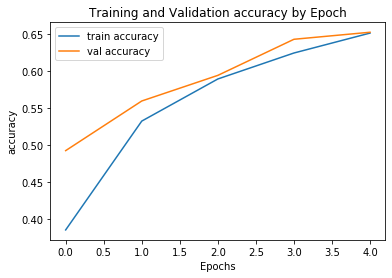

In [58]:
import pandas as pd
hist = pd.DataFrame(history.history)

hist['epoch'] = history.epoch

import matplotlib.pyplot as plt
plt.plot(hist['epoch'], hist['accuracy'], label = "train accuracy")
plt.plot(hist['epoch'], hist['val_accuracy'], label = "val accuracy")
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Training and Validation accuracy by Epoch')
plt.legend()
plt.show()

# This could do with more epochs as seen when the validation performance just starts to decrease.

In [59]:
y_pred = cnn_model.predict(x_test)
print(y_test.shape, y_pred.shape)
# The predictions are generated 

(10000, 1) (10000, 10)


In [60]:
y_pred
# Seems the predictions are generated for each class

array([[1.12208526e-03, 2.66690738e-04, 3.37878801e-03, ...,
        1.23304126e-04, 4.57996368e-01, 4.45286656e-04],
       [3.23746875e-02, 6.90525919e-02, 2.23069183e-05, ...,
        7.35894545e-08, 8.97157550e-01, 1.37919933e-03],
       [2.60372370e-01, 7.12107047e-02, 3.55748623e-03, ...,
        1.08003838e-03, 6.23631120e-01, 3.55528668e-02],
       ...,
       [2.79022410e-04, 2.95608988e-05, 1.24661013e-01, ...,
        8.34388360e-02, 2.13808171e-03, 5.34722116e-04],
       [1.29898600e-02, 2.09840700e-01, 2.00387593e-02, ...,
        2.58671469e-03, 3.71349766e-03, 2.11164283e-04],
       [2.90061398e-05, 1.58449257e-05, 6.22072676e-03, ...,
        8.78121912e-01, 1.22144575e-05, 8.22908332e-05]], dtype=float32)

In [61]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred.argmax(axis=1))


# Pro tip: if you see a model where its predicting as beloinging to a single class, then there is a mistake somewhere
# So whats happening is that the prediction probabilities are very close to 10% anyway and 
# a slight increase is enough to tip off to a single class. This would imply a noise dataset that is impossible to learn from
# So check your scaling

array([[630,  13,  46,  21,  22,   8,  17,  10, 194,  39],
       [ 33, 692,   6,  15,   7,   5,  13,   5, 112, 112],
       [ 62,   7, 505,  56, 106,  82,  75,  41,  55,  11],
       [  8,  12,  79, 449,  94, 174,  77,  46,  48,  13],
       [ 19,   2,  78,  57, 609,  40,  63,  92,  34,   6],
       [ 10,   3,  79, 177,  56, 538,  29,  69,  32,   7],
       [  5,   4,  50,  74,  63,  21, 750,   9,  22,   2],
       [ 10,   2,  29,  37,  92,  84,   7, 710,  13,  16],
       [ 48,  14,  10,  13,   6,   4,   6,   2, 877,  20],
       [ 28,  72,  10,  17,   8,   9,  22,  15,  82, 737]])

In [62]:
test_loss, test_accuracy = cnn_model.evaluate(x_test,  y_test, verbose=0)

In [63]:
test_loss, test_accuracy

(1.0032718181610107, 0.6496999859809875)

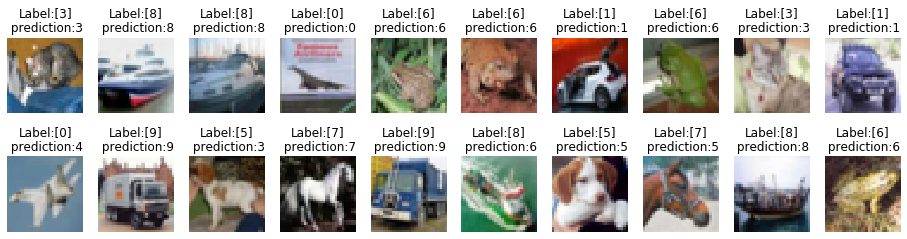

In [64]:
# Plot some examples and check the model’s prediction

plt.figure( figsize=(16,4) )
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(x_test[i].reshape(32,32,3), cmap='gray', interpolation='none')
    plt.title("Label:{}\n prediction:{}".format(y_test[i], y_pred.argmax(axis = 1)[i]))
    plt.axis('off')
    
# The plane seems to be causing issues. One dog is confused with cat, boat confused with frog. Along with horse

# Also some interesting mistakes like between Class 5 (dog) and Class 1 (car) probably because of the tail